In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import pickle


import psutil
psutil.cpu_count()
p = psutil.Process()
p.cpu_affinity([0,1,2,3,4,5,6,7,8,9])

os.chdir(r'H:\all\RL_Shrinkage_2024')
from helpers import helper_functions as hf
from ONE_YR.NonLinear_Shrinkage import regression_evaluation_funcs as re_hf
from helpers import eval_function_new


In [2]:
PF_SIZE = 500


base_folder_path = r'H:\\all\\RL_Shrinkage_2024'
# IMPORT SHRK DATASETS
pf_size = PF_SIZE  # DONT CHANGE HERE!!
permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\permnos_1Y_p{pf_size}.pickle")
rets_full = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\returns_full_1Y_p{pf_size}.pickle")


fixed_shrk_name = 'cov1Para'
opt_shrk_name = 'cov1Para'
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_{fixed_shrk_name}_p{pf_size}.pickle", 'rb') as f:
    fixed_shrk_data = pickle.load(f)
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\{opt_shrk_name}_factor-1.0_p{pf_size}.pickle", 'rb') as f:
    optimal_shrk_data = pickle.load(f)

with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_rawres_{fixed_shrk_name}_p{pf_size}.pickle", 'rb') as f:
    rawres_fixed_shrk_data = pickle.load(f)

# IMPORT FACTORS DATA AND PREPARE FOR FURTHER USE
factor_path = fr"{base_folder_path}\helpers"
factors = pd.read_csv(factor_path + "/all_factors.csv")
factors = factors.pivot(index="date", columns="name", values="ret")

# as our shrk data starts from 1980-01-15 our factors data should too
start_date = str(optimal_shrk_data['date'].iloc[0])
start_date = start_date[0:4] + '-' + start_date[4:6] + "-" + start_date[6:]
start_idx = np.where(factors.index == start_date)[0][0]
factors = factors.iloc[start_idx:start_idx+fixed_shrk_data.shape[0], :]

cov1para_shrk = optimal_shrk_data['shrk_factor'].values[5040:]

len_train = 5040
end_date = fixed_shrk_data.shape[0]
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]

In [3]:
all_res = fixed_shrk_data.iloc[:, 2:].copy() * 100
all_factors = all_res.columns.astype(float).values
Y = all_res.idxmin(axis=1).values.astype(float)
opt_values = all_res.idxmin(axis=1).values.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(0.15, 21))
Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))
opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
opt_v3 = np.diag(all_res.loc[:, all_res.idxmin(axis=1).values])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))

rolling_opt = pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=252, min_periods=1).mean().values


ROLL_WINDOW = 1
ROLL_WINDOW_INPUTS = 252
rolling_opt = pd.Series(opt_values).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values

Y = pd.Series(Y).rolling(window=1, min_periods=1).mean().astype(np.int64).values
opt_values = pd.Series(opt_values).rolling(window=1, min_periods=1).mean().astype(np.int64).values



In [4]:
params = {
'pf_size' : pf_size,
'opt_values_factors' : opt_values,
'include_ts_momentum_var_allstocks': False,
'include_ts_momentum_allstocks': True,
'include_sample_covmat_trace': True,
'include_mean_of_correls': True,
'include_iqr': False,
'include_factors': False,
'include_ewma_year': False,
'include_ewma_month': True,
'include_ew_year_vola': False,
'include_ew_month_vola': True,
'include_allstocks_year_avgvola': True,
'include_allstocks_month_avgvola': False,
    'additional_inputs' : [opt_v3, rolling_opt, rolling_opt2, optimal_shrk_data['shrk_factor'].values.astype(np.float64)*100]  
}

X = re_hf.load_additional_train_data(**params)
X=X.astype(np.float64)


### define all needed data structures to use the imitation package

In [5]:
# first use behavioral cloning

# expert actions --> Y

import gymnasium as gym
from gymnasium.spaces import Box, Discrete
from typing import Optional, Dict, Any

In [10]:

class TimeSeriesEnv(gym.Env):
    """
    Exog. time-series; actions only affect rewards, not future obs.
    """
    def __init__(self, data: np.array, expert_actions: np.array, reward_fn: callable):
        self.state = None
        # save whole train data in env.
        self.data = data
        self.T, self.obs_dim = data.shape
        self.observation_space = Box(-np.inf, np.inf, shape=(self.obs_dim, ) )
        self.action_space = Discrete(n=101) # shrinkage between 0.0 and 1.0, 101 steps
        self.reward_fn = reward_fn
        self.expert_actions = expert_actions
    
    def reset(self, seed=412, **kwargs):
        """
        reset env to an initial state, in our case start of t.s. or just random?
        """
        super().reset(seed=seed)
        self.time_idx = 0
        #self.state = self.observation_space.sample()
        self.state = self.data[self.time_idx]
        return self.state, {}  # 'self.state' can be OOS standard deviation?
    
    def step(self, action):
        """
        from Gymnasium docs;
        Updates an environment with actions returning the next agent observation, 
        the reward for taking that actions, if the environment has terminated or 
        truncated due to the latest action and information from the environment 
        about the step, i.e. metrics, debug info.
        """
        cur_state = self.data[self.time_idx]
        reward = self.reward_fn(np.array(self.expert_actions), (action))
        # next state
        self.idx += 1
        done = self.idx >= self.T
        if not done:
            next_state = self.data[self.idx].copy()
        else:
            next_state = np.zeros_like(cur_state)

        # terminate after one step hence --> can just return None for next_state?
        return next_state, reward, done, False, {}

NameError: name 'gym' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error
myenv = TimeSeriesEnv(data=X, reward_fn=mean_squared_error, expert_actions=Y)

In [ ]:
# register, vectorize, and wrap env to work with imitation apackage
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.util.util import make_vec_env

gym.register(
    id="TimeSeriesEnv",
    entry_point=lambda: TimeSeriesEnv(data=X, reward_fn=mean_squared_error, expert_actions=Y),
    max_episode_steps=len_train,
)

rng = np.random.default_rng(0)
venv = make_vec_env(
    env_name="TimeSeriesEnv",
    rng=rng,
    n_envs=4,
    post_wrappers=[lambda env, _: RolloutInfoWrapper(env)],
)

In [ ]:
# since we have expert actions, just wrap them in SB3-style 'predict()'
class ExpertPolicy:
    def __init__(self, expert_actions: np.ndarray):
        self.actions = expert_actions

    def predict(self, obs, state=None, deterministic=True, time_idx=0):
        # obs has shape (n_envs, obs_dim); we assume all envs sync on a common idx
        # Here we broadcast the precomputed action for the current index:
        batch_size = obs.shape[0]
        # You'll need to track a shared pointer across envs if using vectorized rollouts
        # For simplicity, assume n_envs=1 or handle indexing appropriately
        action = self.actions[self._env_idx]
        return np.repeat(action[None, :], batch_size, axis=0), None


In [ ]:
"""
need to create a 'Transitions' object that contains
{'obs': array([-0.00072172, -0.03225593,  0.00235076,  0.0262831 ], dtype=float32),
 'acts': 1,
 'infos': {},
 'next_obs': array([-0.00136683,  0.16283223,  0.00287643, -0.26565722], dtype=float32),
 'dones': False}
 """
print("")

In [ ]:
from imitation.data.types import Trajectory, TransitionsMinimal, TransitionMapping, Transitions
from imitation.data.rollout import flatten_trajectories

#expert_trajectory = Trajectory(obs=X, acts=Y[:-1], infos=None, terminal=True)

transitions = [{"obs":X[i], "acts":Y[i], "infos":{}, 'next_obs':{}, "dones":True} for i in range(X.shape[0])]
#flatten_trajectories(expert_trajectory)


flattened_transitions=Transitions(obs=X[:len_train], 
            acts=Y.reshape(-1,1)[:len_train], 
            infos=np.array([{} for _ in range(len_train)]),
            next_obs=X[:len_train],
            dones=np.array([True for _ in range(len_train)])
            )

flattened_transitions[0]

In [ ]:
from imitation.algorithms.bc import BC

bc_trainer = BC(
    observation_space=venv.observation_space,
    action_space=venv.action_space,
    demonstrations=flattened_transitions,
    rng=rng
)

#bc_trainer.train(n_epochs=200)

In [ ]:
"""from stable_baselines3.common.evaluation import evaluate_policy
mean_ret, std_ret = evaluate_policy(bc_trainer.policy, venv, n_eval_episodes=20)
print(f"BC performance: {mean_ret:.3f} ± {std_ret:.3f}")5YR"""

In [ ]:
bc_preds = bc_trainer.policy.predict(X[len_train:])[0]

In [ ]:
mapped_res = np.array(re_hf.map_preds_to_factors(bc_preds, all_factors)).astype(float)
#r = eval_function_new.eval_fct_networkonly_1YR(mapped_res, rets_full, permnos, 0, val_indices_results)
#eval_function_new.myplot(mapped_res[val_idxes_shrkges], cov1para_shrk[val_idxes_shrkges])

res_df = pd.DataFrame({"ElasticNet_CVC": mapped_res, "CVC": cov1para_shrk }, index=pd.to_datetime(permnos.index[5040:], format="%Y%m%d") )
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df)
ax.set(xlabel='Year', ylabel='Shrinkage Intensity')
ax.grid()

np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100

In [ ]:
from imitation.algorithms.bc import BC

bc_trainer = BC(
    observation_space=venv.observation_space,
    action_space=venv.action_space,
    demonstrations=flattened_transitions,
    rng=rng
)

bc_trainer.train(n_epochs=200)

### Define and Train GAIL


In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)


In [21]:
X_scaled.mean(axis=0)

array([ 7.21328617e-17, -8.54996660e-16, -5.88429999e-16,  6.44898507e-15,
       -2.86029611e-14,  9.09368420e-18, -3.35686167e-15, -4.48556697e-15,
       -6.04986295e-15,  1.01908243e-15, -3.54201144e-15])

In [28]:
import gymnasium as gym
from gymnasium.spaces import Box, Discrete
from typing import Optional, Dict, Any


class TimeSeriesEnv(gym.Env):
    """
    Exog. time-series; actions only affect rewards, not future obs.
    """
    def __init__(self, data: np.array, expert_actions: np.array, fixed_shrk_data: pd.DataFrame):
        self.state = None
        # save whole train data in env.
        self.data = data
        self.T, self.obs_dim = data.shape
        self.observation_space = Box(-np.inf, np.inf, shape=(self.obs_dim, ) )
        self.action_space = Discrete(n=101) # shrinkage between 0.0 and 1.0, 101 steps
        self.fixed_shrk_data = fixed_shrk_data
    
    def reset(self, seed=412, **kwargs):
        """
        reset env to an initial state, in our case start of t.s. or just random?
        """
        super().reset(seed=seed)
        self.time_idx = 0
        #self.state = self.observation_space.sample()
        self.state = self.data[self.time_idx]
        return self.state, {}  # 'self.state' can be OOS standard deviation?
    
    def step(self, action):
        """
        from Gymnasium docs;
        Updates an environment with actions returning the next agent observation, 
        the reward for taking that actions, if the environment has terminated or 
        truncated due to the latest action and information from the environment 
        about the step, i.e. metrics, debug info.
        """
        cur_state = self.data[self.time_idx]

        # negative OOS vola
        reward = -1 * self.fixed_shrk_data.iloc[self.time_idx, action]
        # next state
        self.time_idx += 1
        done = self.time_idx >= self.T
        if not done:
            next_state = self.data[self.time_idx].copy()
        else:
            next_state = np.zeros_like(cur_state)

        # terminate after one step hence --> can just return None for next_state?
        return next_state, reward, done, False, {}
    


# register, vectorize, and wrap env to work with imitation apackage
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.util.util import make_vec_env
gym.register(
    id="TimeSeriesEnv",
    entry_point=lambda: TimeSeriesEnv(data=X, expert_actions=Y, fixed_shrk_data=fixed_shrk_data.iloc[:, 2:]),
    max_episode_steps=len_train,
)

rng = np.random.default_rng(0)
venv = make_vec_env(
    env_name="TimeSeriesEnv",
    rng=rng,
    n_envs=4,
    post_wrappers=[lambda env, _: RolloutInfoWrapper(env)],
)

from imitation.data.types import Transitions
flattened_transitions=Transitions(
    obs=X[:len_train], 
    acts=Y[:len_train], 
    infos=np.array([{} for _ in range(len_train)]),
    next_obs=X[:len_train],
    dones=np.array([True for _ in range(len_train)])
    )

flattened_transitions[0]

c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment TimeSeriesEnv already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\gymnasium\utils\passive_env_checker.py:175: UserWarning: WARN: The default seed argument in `Env.reset` should be `None`, otherwise the environment will by default always be deterministic. Actual default: seed=412
  logger.warn(
c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not 

{'obs': array([ 1.50000000e+01,  1.63444714e-01,  5.90436631e+01,  3.31176955e-01,
         9.96200000e+00, -1.95747619e-02,  2.22815320e-01,  7.00000000e+00,
         1.50000000e+01,  7.00000000e+00,  7.42271121e+00]),
 'acts': 60,
 'infos': {},
 'next_obs': array([ 1.50000000e+01,  1.63444714e-01,  5.90436631e+01,  3.31176955e-01,
         9.96200000e+00, -1.95747619e-02,  2.22815320e-01,  7.00000000e+00,
         1.50000000e+01,  7.00000000e+00,  7.42271121e+00]),
 'dones': True}

### with random index to train on

In [23]:
"""
class TimeSeriesEnv(gym.Env):
    """
    Exog. time-series; actions only affect rewards, not future obs.
    """
    def __init__(self, data: np.array, expert_actions: np.array, fixed_shrk_data: pd.DataFrame):
        self.state = None
        # save whole train data in env.
        self.data = data
        self.T, self.obs_dim = data.shape
        self.observation_space = Box(-np.inf, np.inf, shape=(self.obs_dim, ) )
        self.action_space = Discrete(n=101) # shrinkage between 0.0 and 1.0, 101 steps
        self.fixed_shrk_data = fixed_shrk_data
    
    def reset(self, seed=412, **kwargs):
        """
        reset env to an initial state, in our case start of t.s. or just random?
        """
        super().reset(seed=seed)
        self.time_idx = np.random.choice(5040)
        #self.state = self.observation_space.sample()
        self.state = self.data[self.time_idx]
        return self.state, {}  # 'self.state' can be OOS standard deviation?
    
    def step(self, action):
        """
        from Gymnasium docs;
        Updates an environment with actions returning the next agent observation, 
        the reward for taking that actions, if the environment has terminated or 
        truncated due to the latest action and information from the environment 
        about the step, i.e. metrics, debug info.
        """
        cur_state = self.data[self.time_idx]

        # negative OOS vola
        reward = -1 * self.fixed_shrk_data.iloc[self.time_idx, action]
        # next state
        done=True
        next_state = np.zeros_like(cur_state)

        # terminate after one step hence --> can just return None for next_state?
        return next_state, reward, done, False, {}
    


# register, vectorize, and wrap env to work with imitation apackage
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.util.util import make_vec_env
gym.register(
    id="TimeSeriesEnv",
    entry_point=lambda: TimeSeriesEnv(data=X, expert_actions=Y, fixed_shrk_data=fixed_shrk_data.iloc[:, 2:]),
    max_episode_steps=len_train,
)

rng = np.random.default_rng(0)
venv = make_vec_env(
    env_name="TimeSeriesEnv",
    rng=rng,
    n_envs=4,
    post_wrappers=[lambda env, _: RolloutInfoWrapper(env)],
)

from imitation.data.types import Transitions
flattened_transitions=Transitions(
    obs=X[:len_train], 
    acts=Y[:len_train], 
    infos=np.array([{} for _ in range(len_train)]),
    next_obs=X[:len_train],
    dones=np.array([True for _ in range(len_train)])
    )

flattened_transitions[0]"""

IndentationError: unexpected indent (2136559929.py, line 4)

In [29]:
from stable_baselines3 import PPO
from imitation.algorithms.adversarial.gail import GAIL
from imitation.rewards.reward_nets import BasicRewardNet
from imitation.util.networks import RunningNorm

# 1) Expert rollouts already in `expert_rollouts`
# 2) Generator
gen_algo = PPO(
    policy="MlpPolicy",
    env=venv,
    batch_size=64,
    n_epochs=5,
    learning_rate=3e-4,
    gamma=0.99,
    seed=0,
)

# 3) Discriminator
disc_net = BasicRewardNet(
    venv.observation_space, venv.action_space, normalize_input_layer=RunningNorm
)
# 4) GAIL trainer
gail = GAIL(
    demonstrations=flattened_transitions,
    demo_batch_size=1024,
    gen_algo=gen_algo,
    reward_net=disc_net,
    venv=venv,
)
gail.train(total_timesteps=1_000_000)
gail_policy = gail.gen_algo.policy


# register, vectorize, and wrap env to work with imitation apackage
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.util.util import make_vec_env

gym.register(
    id="TimeSeriesEnv",
    entry_point=lambda: TimeSeriesEnv(data=X, expert_actions=Y, fixed_shrk_data=fixed_shrk_data),
    max_episode_steps=len_train,
)

rng = np.random.default_rng(0)
venv = make_vec_env(
    env_name="TimeSeriesEnv",
    rng=rng,
    n_envs=4,
    post_wrappers=[lambda env, _: RolloutInfoWrapper(env)],
)

round:   0%|          | 0/122 [00:00<?, ?it/s]c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


--------------------------------------
| raw/                        |      |
|    gen/time/fps             | 1808 |
|    gen/time/iterations      | 1    |
|    gen/time/time_elapsed    | 4    |
|    gen/time/total_timesteps | 8192 |
--------------------------------------
--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.491    |
|    disc/disc_acc_expert             | 0.116    |
|    disc/disc_acc_gen                | 0.866    |
|    disc/disc_entropy                | 0.692    |
|    disc/disc_loss                   | 0.696    |
|    disc/disc_proportion_expert_pred | 0.125    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 1        |
|    disc/n_expert                    | 1.02e+03 |
|    disc/n_generated                 | 1.02e+03 |
--------------------------------------------------
--------------------------------------------------
| raw/       

round:   1%|          | 1/122 [00:08<18:01,  8.94s/it]

--------------------------------------------------
| raw/                              |            |
|    gen/time/fps                   | 1540       |
|    gen/time/iterations            | 1          |
|    gen/time/time_elapsed          | 5          |
|    gen/time/total_timesteps       | 16384      |
|    gen/train/approx_kl            | 0.01174162 |
|    gen/train/clip_fraction        | 0.142      |
|    gen/train/clip_range           | 0.2        |
|    gen/train/entropy_loss         | -4.61      |
|    gen/train/explained_variance   | 0.0216     |
|    gen/train/learning_rate        | 0.0003     |
|    gen/train/loss                 | 0.0844     |
|    gen/train/n_updates            | 5          |
|    gen/train/policy_gradient_loss | -0.0149    |
|    gen/train/value_loss           | 11.9       |
--------------------------------------------------
--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc             

round:   2%|▏         | 2/122 [00:17<17:41,  8.84s/it]

---------------------------------------------------
| raw/                              |             |
|    gen/rollout/ep_len_mean        | 5.04e+03    |
|    gen/rollout/ep_rew_mean        | -716        |
|    gen/time/fps                   | 2047        |
|    gen/time/iterations            | 1           |
|    gen/time/time_elapsed          | 4           |
|    gen/time/total_timesteps       | 24576       |
|    gen/train/approx_kl            | 0.013257105 |
|    gen/train/clip_fraction        | 0.0856      |
|    gen/train/clip_range           | 0.2         |
|    gen/train/entropy_loss         | -4.6        |
|    gen/train/explained_variance   | 0.376       |
|    gen/train/learning_rate        | 0.0003      |
|    gen/train/loss                 | 0.0416      |
|    gen/train/n_updates            | 10          |
|    gen/train/policy_gradient_loss | -0.00735    |
|    gen/train/value_loss           | 11.7        |
---------------------------------------------------
------------

round:   2%|▏         | 3/122 [00:24<15:46,  7.95s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -716        |
|    gen/rollout/ep_rew_wrapped_mean | 3.36e+03    |
|    gen/time/fps                    | 2084        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 32768       |
|    gen/train/approx_kl             | 0.013732554 |
|    gen/train/clip_fraction         | 0.13        |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -4.58       |
|    gen/train/explained_variance    | 0.0972      |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.157       |
|    gen/train/n_updates             | 15          |
|    gen/train/policy_gradient_loss  | -0.0104     |
|    gen/train/value_loss            | 7.74   

round:   3%|▎         | 4/122 [00:31<14:44,  7.49s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -692        |
|    gen/rollout/ep_rew_wrapped_mean | 3.36e+03    |
|    gen/time/fps                    | 2098        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 40960       |
|    gen/train/approx_kl             | 0.013173059 |
|    gen/train/clip_fraction         | 0.104       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -4.56       |
|    gen/train/explained_variance    | 0.696       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.00435     |
|    gen/train/n_updates             | 20          |
|    gen/train/policy_gradient_loss  | -0.0098     |
|    gen/train/value_loss            | 4.6    

round:   4%|▍         | 5/122 [00:38<14:02,  7.20s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -692       |
|    gen/rollout/ep_rew_wrapped_mean | 3.36e+03   |
|    gen/time/fps                    | 2077       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 3          |
|    gen/time/total_timesteps        | 49152      |
|    gen/train/approx_kl             | 0.01590882 |
|    gen/train/clip_fraction         | 0.197      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -4.52      |
|    gen/train/explained_variance    | 0.179      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | 0.227      |
|    gen/train/n_updates             | 25         |
|    gen/train/policy_gradient_loss  | -0.0151    |
|    gen/train/value_loss            | 2.76       |
------------

round:   5%|▍         | 6/122 [00:44<13:39,  7.07s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -692       |
|    gen/rollout/ep_rew_wrapped_mean | 3.36e+03   |
|    gen/time/fps                    | 2138       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 3          |
|    gen/time/total_timesteps        | 57344      |
|    gen/train/approx_kl             | 0.01554908 |
|    gen/train/clip_fraction         | 0.181      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -4.47      |
|    gen/train/explained_variance    | 0.845      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | -0.0414    |
|    gen/train/n_updates             | 30         |
|    gen/train/policy_gradient_loss  | -0.0154    |
|    gen/train/value_loss            | 1.58       |
------------

round:   6%|▌         | 7/122 [00:51<13:15,  6.91s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -701        |
|    gen/rollout/ep_rew_wrapped_mean | 3.36e+03    |
|    gen/time/fps                    | 2112        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 65536       |
|    gen/train/approx_kl             | 0.016293272 |
|    gen/train/clip_fraction         | 0.264       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -4.41       |
|    gen/train/explained_variance    | -0.0787     |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0573      |
|    gen/train/n_updates             | 35          |
|    gen/train/policy_gradient_loss  | -0.022      |
|    gen/train/value_loss            | 1.03   

round:   7%|▋         | 8/122 [00:58<13:00,  6.85s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -701        |
|    gen/rollout/ep_rew_wrapped_mean | 3.37e+03    |
|    gen/time/fps                    | 2140        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 73728       |
|    gen/train/approx_kl             | 0.016789626 |
|    gen/train/clip_fraction         | 0.26        |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -4.31       |
|    gen/train/explained_variance    | 0.427       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0479     |
|    gen/train/n_updates             | 40          |
|    gen/train/policy_gradient_loss  | -0.0227     |
|    gen/train/value_loss            | 0.656  

round:   7%|▋         | 9/122 [01:04<12:44,  6.76s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -665        |
|    gen/rollout/ep_rew_wrapped_mean | 3.37e+03    |
|    gen/time/fps                    | 1943        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 81920       |
|    gen/train/approx_kl             | 0.015226776 |
|    gen/train/clip_fraction         | 0.226       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -4.25       |
|    gen/train/explained_variance    | 0.863       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.00917     |
|    gen/train/n_updates             | 45          |
|    gen/train/policy_gradient_loss  | -0.0186     |
|    gen/train/value_loss            | 0.379  

round:   8%|▊         | 10/122 [01:12<12:56,  6.93s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -665        |
|    gen/rollout/ep_rew_wrapped_mean | 3.38e+03    |
|    gen/time/fps                    | 1619        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 90112       |
|    gen/train/approx_kl             | 0.016015798 |
|    gen/train/clip_fraction         | 0.233       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -4.16       |
|    gen/train/explained_variance    | 0.511       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.00934    |
|    gen/train/n_updates             | 50          |
|    gen/train/policy_gradient_loss  | -0.0208     |
|    gen/train/value_loss            | 0.244  

round:   9%|▉         | 11/122 [01:20<13:26,  7.27s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -665        |
|    gen/rollout/ep_rew_wrapped_mean | 3.38e+03    |
|    gen/time/fps                    | 2077        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 98304       |
|    gen/train/approx_kl             | 0.014714712 |
|    gen/train/clip_fraction         | 0.212       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -4.11       |
|    gen/train/explained_variance    | 0.862       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0114     |
|    gen/train/n_updates             | 55          |
|    gen/train/policy_gradient_loss  | -0.0197     |
|    gen/train/value_loss            | 0.147  

round:  10%|▉         | 12/122 [01:27<13:10,  7.19s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -623        |
|    gen/rollout/ep_rew_wrapped_mean | 3.38e+03    |
|    gen/time/fps                    | 2109        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 106496      |
|    gen/train/approx_kl             | 0.017023407 |
|    gen/train/clip_fraction         | 0.257       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -4.03       |
|    gen/train/explained_variance    | 0.317       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0153     |
|    gen/train/n_updates             | 60          |
|    gen/train/policy_gradient_loss  | -0.0229     |
|    gen/train/value_loss            | 0.0819 

round:  11%|█         | 13/122 [01:34<12:58,  7.14s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -623        |
|    gen/rollout/ep_rew_wrapped_mean | 3.4e+03     |
|    gen/time/fps                    | 1926        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 114688      |
|    gen/train/approx_kl             | 0.012358769 |
|    gen/train/clip_fraction         | 0.187       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.97       |
|    gen/train/explained_variance    | 0.579       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0515     |
|    gen/train/n_updates             | 65          |
|    gen/train/policy_gradient_loss  | -0.0175     |
|    gen/train/value_loss            | 0.0726 

round:  11%|█▏        | 14/122 [01:41<12:50,  7.14s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -635       |
|    gen/rollout/ep_rew_wrapped_mean | 3.4e+03    |
|    gen/time/fps                    | 1955       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 122880     |
|    gen/train/approx_kl             | 0.01530827 |
|    gen/train/clip_fraction         | 0.223      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -3.94      |
|    gen/train/explained_variance    | 0.79       |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | 0.0079     |
|    gen/train/n_updates             | 70         |
|    gen/train/policy_gradient_loss  | -0.0192    |
|    gen/train/value_loss            | 0.0441     |
------------

round:  12%|█▏        | 15/122 [01:48<12:35,  7.07s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -635        |
|    gen/rollout/ep_rew_wrapped_mean | 3.4e+03     |
|    gen/time/fps                    | 2088        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 131072      |
|    gen/train/approx_kl             | 0.015692396 |
|    gen/train/clip_fraction         | 0.253       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.93       |
|    gen/train/explained_variance    | 0.502       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.026      |
|    gen/train/n_updates             | 75          |
|    gen/train/policy_gradient_loss  | -0.0251     |
|    gen/train/value_loss            | 0.0358 

round:  13%|█▎        | 16/122 [01:54<12:17,  6.95s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -635        |
|    gen/rollout/ep_rew_wrapped_mean | 3.4e+03     |
|    gen/time/fps                    | 1702        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 139264      |
|    gen/train/approx_kl             | 0.016788185 |
|    gen/train/clip_fraction         | 0.262       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.91       |
|    gen/train/explained_variance    | 0.812       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0305     |
|    gen/train/n_updates             | 80          |
|    gen/train/policy_gradient_loss  | -0.0235     |
|    gen/train/value_loss            | 0.0257 

round:  14%|█▍        | 17/122 [02:02<12:40,  7.24s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -599       |
|    gen/rollout/ep_rew_wrapped_mean | 3.4e+03    |
|    gen/time/fps                    | 2052       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 3          |
|    gen/time/total_timesteps        | 147456     |
|    gen/train/approx_kl             | 0.01831645 |
|    gen/train/clip_fraction         | 0.332      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -3.89      |
|    gen/train/explained_variance    | 0.121      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | -0.0374    |
|    gen/train/n_updates             | 85         |
|    gen/train/policy_gradient_loss  | -0.0319    |
|    gen/train/value_loss            | 0.0207     |
------------

round:  15%|█▍        | 18/122 [02:09<12:17,  7.09s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -599        |
|    gen/rollout/ep_rew_wrapped_mean | 3.41e+03    |
|    gen/time/fps                    | 2128        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 155648      |
|    gen/train/approx_kl             | 0.018454257 |
|    gen/train/clip_fraction         | 0.317       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.89       |
|    gen/train/explained_variance    | 0.41        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0042     |
|    gen/train/n_updates             | 90          |
|    gen/train/policy_gradient_loss  | -0.0308     |
|    gen/train/value_loss            | 0.0237 

round:  16%|█▌        | 19/122 [02:16<11:57,  6.97s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -570        |
|    gen/rollout/ep_rew_wrapped_mean | 3.41e+03    |
|    gen/time/fps                    | 1369        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 163840      |
|    gen/train/approx_kl             | 0.018579645 |
|    gen/train/clip_fraction         | 0.367       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.81       |
|    gen/train/explained_variance    | 0.668       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0407     |
|    gen/train/n_updates             | 95          |
|    gen/train/policy_gradient_loss  | -0.0389     |
|    gen/train/value_loss            | 0.0186 

round:  16%|█▋        | 20/122 [02:25<12:55,  7.61s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -570        |
|    gen/rollout/ep_rew_wrapped_mean | 3.42e+03    |
|    gen/time/fps                    | 1806        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 172032      |
|    gen/train/approx_kl             | 0.017726876 |
|    gen/train/clip_fraction         | 0.337       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.77       |
|    gen/train/explained_variance    | 0.529       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0353     |
|    gen/train/n_updates             | 100         |
|    gen/train/policy_gradient_loss  | -0.0364     |
|    gen/train/value_loss            | 0.0222 

round:  17%|█▋        | 21/122 [02:32<12:40,  7.53s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -570        |
|    gen/rollout/ep_rew_wrapped_mean | 3.42e+03    |
|    gen/time/fps                    | 2000        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 180224      |
|    gen/train/approx_kl             | 0.016329136 |
|    gen/train/clip_fraction         | 0.293       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.71       |
|    gen/train/explained_variance    | 0.653       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0162     |
|    gen/train/n_updates             | 105         |
|    gen/train/policy_gradient_loss  | -0.0313     |
|    gen/train/value_loss            | 0.0171 

round:  18%|█▊        | 22/122 [02:39<12:16,  7.37s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -547        |
|    gen/rollout/ep_rew_wrapped_mean | 3.42e+03    |
|    gen/time/fps                    | 2033        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 188416      |
|    gen/train/approx_kl             | 0.017623192 |
|    gen/train/clip_fraction         | 0.346       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.68       |
|    gen/train/explained_variance    | 0.328       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0324     |
|    gen/train/n_updates             | 110         |
|    gen/train/policy_gradient_loss  | -0.0371     |
|    gen/train/value_loss            | 0.0111 

round:  19%|█▉        | 23/122 [02:46<11:56,  7.24s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -547        |
|    gen/rollout/ep_rew_wrapped_mean | 3.43e+03    |
|    gen/time/fps                    | 1864        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 196608      |
|    gen/train/approx_kl             | 0.017890958 |
|    gen/train/clip_fraction         | 0.338       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.72       |
|    gen/train/explained_variance    | 0.559       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0247     |
|    gen/train/n_updates             | 115         |
|    gen/train/policy_gradient_loss  | -0.033      |
|    gen/train/value_loss            | 0.0149 

round:  20%|█▉        | 24/122 [02:53<11:54,  7.29s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -530        |
|    gen/rollout/ep_rew_wrapped_mean | 3.43e+03    |
|    gen/time/fps                    | 1967        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 204800      |
|    gen/train/approx_kl             | 0.018077403 |
|    gen/train/clip_fraction         | 0.343       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.63       |
|    gen/train/explained_variance    | 0.354       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0101      |
|    gen/train/n_updates             | 120         |
|    gen/train/policy_gradient_loss  | -0.0364     |
|    gen/train/value_loss            | 0.0101 

round:  20%|██        | 25/122 [03:00<11:37,  7.19s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -530        |
|    gen/rollout/ep_rew_wrapped_mean | 3.44e+03    |
|    gen/time/fps                    | 2059        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 212992      |
|    gen/train/approx_kl             | 0.016552415 |
|    gen/train/clip_fraction         | 0.296       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.68       |
|    gen/train/explained_variance    | 0.673       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0242     |
|    gen/train/n_updates             | 125         |
|    gen/train/policy_gradient_loss  | -0.0318     |
|    gen/train/value_loss            | 0.0123 

round:  21%|██▏       | 26/122 [03:08<11:29,  7.19s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -530       |
|    gen/rollout/ep_rew_wrapped_mean | 3.44e+03   |
|    gen/time/fps                    | 1998       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 221184     |
|    gen/train/approx_kl             | 0.04293545 |
|    gen/train/clip_fraction         | 0.377      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -3.7       |
|    gen/train/explained_variance    | 0.368      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | -0.0207    |
|    gen/train/n_updates             | 130        |
|    gen/train/policy_gradient_loss  | -0.0387    |
|    gen/train/value_loss            | 0.0156     |
------------

round:  22%|██▏       | 27/122 [03:15<11:18,  7.14s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -515        |
|    gen/rollout/ep_rew_wrapped_mean | 3.44e+03    |
|    gen/time/fps                    | 2075        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 229376      |
|    gen/train/approx_kl             | 0.032857053 |
|    gen/train/clip_fraction         | 0.376       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.7        |
|    gen/train/explained_variance    | 0.471       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0594     |
|    gen/train/n_updates             | 135         |
|    gen/train/policy_gradient_loss  | -0.0425     |
|    gen/train/value_loss            | 0.0172 

round:  23%|██▎       | 28/122 [03:21<11:00,  7.02s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -515        |
|    gen/rollout/ep_rew_wrapped_mean | 3.45e+03    |
|    gen/time/fps                    | 1547        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 237568      |
|    gen/train/approx_kl             | 0.018175937 |
|    gen/train/clip_fraction         | 0.315       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.68       |
|    gen/train/explained_variance    | 0.479       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0115     |
|    gen/train/n_updates             | 140         |
|    gen/train/policy_gradient_loss  | -0.0357     |
|    gen/train/value_loss            | 0.0397 

round:  24%|██▍       | 29/122 [03:30<11:26,  7.38s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -502        |
|    gen/rollout/ep_rew_wrapped_mean | 3.45e+03    |
|    gen/time/fps                    | 2020        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 245760      |
|    gen/train/approx_kl             | 0.020275008 |
|    gen/train/clip_fraction         | 0.355       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.57       |
|    gen/train/explained_variance    | 0.432       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0507     |
|    gen/train/n_updates             | 145         |
|    gen/train/policy_gradient_loss  | -0.0384     |
|    gen/train/value_loss            | 0.0309 

round:  25%|██▍       | 30/122 [03:37<11:10,  7.29s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -502        |
|    gen/rollout/ep_rew_wrapped_mean | 3.47e+03    |
|    gen/time/fps                    | 1993        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 253952      |
|    gen/train/approx_kl             | 0.018872216 |
|    gen/train/clip_fraction         | 0.376       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.56       |
|    gen/train/explained_variance    | 0.615       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0181     |
|    gen/train/n_updates             | 150         |
|    gen/train/policy_gradient_loss  | -0.0418     |
|    gen/train/value_loss            | 0.0323 

round:  25%|██▌       | 31/122 [03:44<11:16,  7.43s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -492        |
|    gen/rollout/ep_rew_wrapped_mean | 3.47e+03    |
|    gen/time/fps                    | 1981        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 262144      |
|    gen/train/approx_kl             | 0.016684493 |
|    gen/train/clip_fraction         | 0.334       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.47       |
|    gen/train/explained_variance    | 0.638       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.00785     |
|    gen/train/n_updates             | 155         |
|    gen/train/policy_gradient_loss  | -0.0321     |
|    gen/train/value_loss            | 0.0362 

round:  26%|██▌       | 32/122 [03:52<11:20,  7.56s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -492        |
|    gen/rollout/ep_rew_wrapped_mean | 3.49e+03    |
|    gen/time/fps                    | 1684        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 270336      |
|    gen/train/approx_kl             | 0.018721247 |
|    gen/train/clip_fraction         | 0.285       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.4        |
|    gen/train/explained_variance    | 0.686       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.034      |
|    gen/train/n_updates             | 160         |
|    gen/train/policy_gradient_loss  | -0.0315     |
|    gen/train/value_loss            | 0.0217 

round:  27%|██▋       | 33/122 [04:00<11:24,  7.70s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -492       |
|    gen/rollout/ep_rew_wrapped_mean | 3.49e+03   |
|    gen/time/fps                    | 1992       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 278528     |
|    gen/train/approx_kl             | 0.01898284 |
|    gen/train/clip_fraction         | 0.326      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -3.41      |
|    gen/train/explained_variance    | 0.591      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | -0.00667   |
|    gen/train/n_updates             | 165        |
|    gen/train/policy_gradient_loss  | -0.0296    |
|    gen/train/value_loss            | 0.0268     |
------------

round:  28%|██▊       | 34/122 [04:08<11:20,  7.74s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -484        |
|    gen/rollout/ep_rew_wrapped_mean | 3.49e+03    |
|    gen/time/fps                    | 1939        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 286720      |
|    gen/train/approx_kl             | 0.022194834 |
|    gen/train/clip_fraction         | 0.346       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.38       |
|    gen/train/explained_variance    | 0.335       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0686     |
|    gen/train/n_updates             | 170         |
|    gen/train/policy_gradient_loss  | -0.0364     |
|    gen/train/value_loss            | 0.011  

round:  29%|██▊       | 35/122 [04:15<11:01,  7.60s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -484        |
|    gen/rollout/ep_rew_wrapped_mean | 3.49e+03    |
|    gen/time/fps                    | 2109        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 294912      |
|    gen/train/approx_kl             | 0.036267884 |
|    gen/train/clip_fraction         | 0.335       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.59       |
|    gen/train/explained_variance    | 0.506       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0334     |
|    gen/train/n_updates             | 175         |
|    gen/train/policy_gradient_loss  | -0.0375     |
|    gen/train/value_loss            | 0.0163 

round:  30%|██▉       | 36/122 [04:22<10:37,  7.42s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -477        |
|    gen/rollout/ep_rew_wrapped_mean | 3.49e+03    |
|    gen/time/fps                    | 1956        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 303104      |
|    gen/train/approx_kl             | 0.029760886 |
|    gen/train/clip_fraction         | 0.35        |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.61       |
|    gen/train/explained_variance    | 0.537       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.026      |
|    gen/train/n_updates             | 180         |
|    gen/train/policy_gradient_loss  | -0.0368     |
|    gen/train/value_loss            | 0.0247 

round:  30%|███       | 37/122 [04:31<10:56,  7.73s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -477       |
|    gen/rollout/ep_rew_wrapped_mean | 3.5e+03    |
|    gen/time/fps                    | 1725       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 311296     |
|    gen/train/approx_kl             | 0.03515073 |
|    gen/train/clip_fraction         | 0.344      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -3.56      |
|    gen/train/explained_variance    | 0.604      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | -0.0353    |
|    gen/train/n_updates             | 185        |
|    gen/train/policy_gradient_loss  | -0.0359    |
|    gen/train/value_loss            | 0.0286     |
------------

round:  31%|███       | 38/122 [04:39<11:05,  7.92s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -477        |
|    gen/rollout/ep_rew_wrapped_mean | 3.5e+03     |
|    gen/time/fps                    | 2000        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 319488      |
|    gen/train/approx_kl             | 0.022208553 |
|    gen/train/clip_fraction         | 0.38        |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.66       |
|    gen/train/explained_variance    | 0.228       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0573     |
|    gen/train/n_updates             | 190         |
|    gen/train/policy_gradient_loss  | -0.0415     |
|    gen/train/value_loss            | 0.0503 

round:  32%|███▏      | 39/122 [04:46<10:37,  7.69s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -472       |
|    gen/rollout/ep_rew_wrapped_mean | 3.5e+03    |
|    gen/time/fps                    | 1807       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 327680     |
|    gen/train/approx_kl             | 0.02061007 |
|    gen/train/clip_fraction         | 0.386      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -3.6       |
|    gen/train/explained_variance    | 0.263      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | -0.0399    |
|    gen/train/n_updates             | 195        |
|    gen/train/policy_gradient_loss  | -0.0408    |
|    gen/train/value_loss            | 0.0323     |
------------

round:  33%|███▎      | 40/122 [04:54<10:24,  7.62s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -472        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 1923        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 335872      |
|    gen/train/approx_kl             | 0.018201645 |
|    gen/train/clip_fraction         | 0.306       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.55       |
|    gen/train/explained_variance    | 0.765       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0552     |
|    gen/train/n_updates             | 200         |
|    gen/train/policy_gradient_loss  | -0.0279     |
|    gen/train/value_loss            | 0.0309 

round:  34%|███▎      | 41/122 [05:01<10:11,  7.55s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -473        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 1778        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 344064      |
|    gen/train/approx_kl             | 0.029941572 |
|    gen/train/clip_fraction         | 0.347       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.58       |
|    gen/train/explained_variance    | 0.275       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0225     |
|    gen/train/n_updates             | 205         |
|    gen/train/policy_gradient_loss  | -0.0373     |
|    gen/train/value_loss            | 0.0205 

round:  34%|███▍      | 42/122 [05:09<10:06,  7.58s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -473        |
|    gen/rollout/ep_rew_wrapped_mean | 3.52e+03    |
|    gen/time/fps                    | 1922        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 352256      |
|    gen/train/approx_kl             | 0.018776938 |
|    gen/train/clip_fraction         | 0.29        |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.57       |
|    gen/train/explained_variance    | 0.877       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0075     |
|    gen/train/n_updates             | 210         |
|    gen/train/policy_gradient_loss  | -0.0281     |
|    gen/train/value_loss            | 0.0231 

round:  35%|███▌      | 43/122 [05:16<09:52,  7.50s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -473        |
|    gen/rollout/ep_rew_wrapped_mean | 3.52e+03    |
|    gen/time/fps                    | 2024        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 360448      |
|    gen/train/approx_kl             | 0.021840302 |
|    gen/train/clip_fraction         | 0.373       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.54       |
|    gen/train/explained_variance    | 0.638       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0362     |
|    gen/train/n_updates             | 215         |
|    gen/train/policy_gradient_loss  | -0.0402     |
|    gen/train/value_loss            | 0.0153 

round:  36%|███▌      | 44/122 [05:23<09:34,  7.36s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -469        |
|    gen/rollout/ep_rew_wrapped_mean | 3.52e+03    |
|    gen/time/fps                    | 2016        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 368640      |
|    gen/train/approx_kl             | 0.021831248 |
|    gen/train/clip_fraction         | 0.35        |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.51       |
|    gen/train/explained_variance    | 0.684       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0626     |
|    gen/train/n_updates             | 220         |
|    gen/train/policy_gradient_loss  | -0.0395     |
|    gen/train/value_loss            | 0.0134 

round:  37%|███▋      | 45/122 [05:30<09:15,  7.22s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -469        |
|    gen/rollout/ep_rew_wrapped_mean | 3.52e+03    |
|    gen/time/fps                    | 1781        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 376832      |
|    gen/train/approx_kl             | 0.017111177 |
|    gen/train/clip_fraction         | 0.265       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.56       |
|    gen/train/explained_variance    | 0.9         |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.00965    |
|    gen/train/n_updates             | 225         |
|    gen/train/policy_gradient_loss  | -0.0273     |
|    gen/train/value_loss            | 0.0222 

round:  38%|███▊      | 46/122 [05:39<09:49,  7.75s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -465       |
|    gen/rollout/ep_rew_wrapped_mean | 3.52e+03   |
|    gen/time/fps                    | 1872       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 385024     |
|    gen/train/approx_kl             | 0.03546393 |
|    gen/train/clip_fraction         | 0.351      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -3.5       |
|    gen/train/explained_variance    | 0.404      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | -0.0674    |
|    gen/train/n_updates             | 230        |
|    gen/train/policy_gradient_loss  | -0.0385    |
|    gen/train/value_loss            | 0.0115     |
------------

round:  39%|███▊      | 47/122 [05:46<09:30,  7.60s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -465        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 2141        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 393216      |
|    gen/train/approx_kl             | 0.030460516 |
|    gen/train/clip_fraction         | 0.323       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.52       |
|    gen/train/explained_variance    | 0.873       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0303     |
|    gen/train/n_updates             | 235         |
|    gen/train/policy_gradient_loss  | -0.038      |
|    gen/train/value_loss            | 0.0151 

round:  39%|███▉      | 48/122 [05:53<09:00,  7.31s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -465        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 2104        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 401408      |
|    gen/train/approx_kl             | 0.022393186 |
|    gen/train/clip_fraction         | 0.355       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.5        |
|    gen/train/explained_variance    | 0.564       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0364     |
|    gen/train/n_updates             | 240         |
|    gen/train/policy_gradient_loss  | -0.039      |
|    gen/train/value_loss            | 0.0143 

round:  40%|████      | 49/122 [06:00<08:39,  7.12s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -460       |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03   |
|    gen/time/fps                    | 2042       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 409600     |
|    gen/train/approx_kl             | 0.03489875 |
|    gen/train/clip_fraction         | 0.373      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -3.52      |
|    gen/train/explained_variance    | 0.663      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | -0.00679   |
|    gen/train/n_updates             | 245        |
|    gen/train/policy_gradient_loss  | -0.0398    |
|    gen/train/value_loss            | 0.0162     |
------------

round:  41%|████      | 50/122 [06:07<08:29,  7.07s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -460        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 1973        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 417792      |
|    gen/train/approx_kl             | 0.023861667 |
|    gen/train/clip_fraction         | 0.362       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.54       |
|    gen/train/explained_variance    | 0.633       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0667     |
|    gen/train/n_updates             | 250         |
|    gen/train/policy_gradient_loss  | -0.036      |
|    gen/train/value_loss            | 0.0269 

round:  42%|████▏     | 51/122 [06:14<08:21,  7.06s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -457        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 2018        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 425984      |
|    gen/train/approx_kl             | 0.020980503 |
|    gen/train/clip_fraction         | 0.385       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.54       |
|    gen/train/explained_variance    | 0.488       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0269     |
|    gen/train/n_updates             | 255         |
|    gen/train/policy_gradient_loss  | -0.0411     |
|    gen/train/value_loss            | 0.0262 

round:  43%|████▎     | 52/122 [06:21<08:11,  7.02s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -457        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 2075        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 434176      |
|    gen/train/approx_kl             | 0.023737803 |
|    gen/train/clip_fraction         | 0.433       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.51       |
|    gen/train/explained_variance    | 0.577       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0451     |
|    gen/train/n_updates             | 260         |
|    gen/train/policy_gradient_loss  | -0.0458     |
|    gen/train/value_loss            | 0.0276 

round:  43%|████▎     | 53/122 [06:28<08:10,  7.11s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -457        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 1953        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 442368      |
|    gen/train/approx_kl             | 0.020368315 |
|    gen/train/clip_fraction         | 0.38        |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.65       |
|    gen/train/explained_variance    | 0.182       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0128      |
|    gen/train/n_updates             | 265         |
|    gen/train/policy_gradient_loss  | -0.0393     |
|    gen/train/value_loss            | 0.031  

round:  44%|████▍     | 54/122 [06:35<08:01,  7.07s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -454        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 1929        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 450560      |
|    gen/train/approx_kl             | 0.023052035 |
|    gen/train/clip_fraction         | 0.413       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.63       |
|    gen/train/explained_variance    | 0.214       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.00601     |
|    gen/train/n_updates             | 270         |
|    gen/train/policy_gradient_loss  | -0.0438     |
|    gen/train/value_loss            | 0.0367 

round:  45%|████▌     | 55/122 [06:43<08:14,  7.39s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -454        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 1989        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 458752      |
|    gen/train/approx_kl             | 0.022556607 |
|    gen/train/clip_fraction         | 0.361       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.62       |
|    gen/train/explained_variance    | 0.213       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.033      |
|    gen/train/n_updates             | 275         |
|    gen/train/policy_gradient_loss  | -0.0373     |
|    gen/train/value_loss            | 0.0472 

round:  46%|████▌     | 56/122 [06:50<08:00,  7.28s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -452        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 1963        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 466944      |
|    gen/train/approx_kl             | 0.024950262 |
|    gen/train/clip_fraction         | 0.325       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.61       |
|    gen/train/explained_variance    | 0.775       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0438      |
|    gen/train/n_updates             | 280         |
|    gen/train/policy_gradient_loss  | -0.0339     |
|    gen/train/value_loss            | 0.0516 

round:  47%|████▋     | 57/122 [06:57<07:49,  7.22s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -452        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 1976        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 475136      |
|    gen/train/approx_kl             | 0.020151716 |
|    gen/train/clip_fraction         | 0.342       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.51       |
|    gen/train/explained_variance    | 0.059       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.00634    |
|    gen/train/n_updates             | 285         |
|    gen/train/policy_gradient_loss  | -0.0369     |
|    gen/train/value_loss            | 0.0697 

round:  48%|████▊     | 58/122 [07:04<07:36,  7.13s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -452        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 2109        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 483328      |
|    gen/train/approx_kl             | 0.019656004 |
|    gen/train/clip_fraction         | 0.319       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.56       |
|    gen/train/explained_variance    | 0.704       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.00157     |
|    gen/train/n_updates             | 290         |
|    gen/train/policy_gradient_loss  | -0.0327     |
|    gen/train/value_loss            | 0.0653 

round:  48%|████▊     | 59/122 [07:11<07:21,  7.00s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -451        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 2081        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 491520      |
|    gen/train/approx_kl             | 0.022461435 |
|    gen/train/clip_fraction         | 0.375       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.53       |
|    gen/train/explained_variance    | 0.323       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0382     |
|    gen/train/n_updates             | 295         |
|    gen/train/policy_gradient_loss  | -0.0406     |
|    gen/train/value_loss            | 0.0618 

round:  49%|████▉     | 60/122 [07:18<07:10,  6.94s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -451        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 2048        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 499712      |
|    gen/train/approx_kl             | 0.018943004 |
|    gen/train/clip_fraction         | 0.329       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.53       |
|    gen/train/explained_variance    | 0.549       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0212      |
|    gen/train/n_updates             | 300         |
|    gen/train/policy_gradient_loss  | -0.0347     |
|    gen/train/value_loss            | 0.0631 

round:  50%|█████     | 61/122 [07:25<07:05,  6.97s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -448       |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03   |
|    gen/time/fps                    | 2071       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 3          |
|    gen/time/total_timesteps        | 507904     |
|    gen/train/approx_kl             | 0.02238297 |
|    gen/train/clip_fraction         | 0.379      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -3.54      |
|    gen/train/explained_variance    | 0.736      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | -0.0277    |
|    gen/train/n_updates             | 305        |
|    gen/train/policy_gradient_loss  | -0.0415    |
|    gen/train/value_loss            | 0.0612     |
------------

round:  51%|█████     | 62/122 [07:31<06:54,  6.90s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -448        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 2132        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 516096      |
|    gen/train/approx_kl             | 0.019011278 |
|    gen/train/clip_fraction         | 0.323       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.38       |
|    gen/train/explained_variance    | 0.574       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0363      |
|    gen/train/n_updates             | 310         |
|    gen/train/policy_gradient_loss  | -0.0331     |
|    gen/train/value_loss            | 0.0702 

round:  52%|█████▏    | 63/122 [07:38<06:45,  6.87s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -435        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 1839        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 524288      |
|    gen/train/approx_kl             | 0.019726792 |
|    gen/train/clip_fraction         | 0.354       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.39       |
|    gen/train/explained_variance    | 0.807       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0156     |
|    gen/train/n_updates             | 315         |
|    gen/train/policy_gradient_loss  | -0.0361     |
|    gen/train/value_loss            | 0.0725 

round:  52%|█████▏    | 64/122 [07:47<07:04,  7.32s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -435       |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03   |
|    gen/time/fps                    | 1571       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 5          |
|    gen/time/total_timesteps        | 532480     |
|    gen/train/approx_kl             | 0.02032193 |
|    gen/train/clip_fraction         | 0.339      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -3.28      |
|    gen/train/explained_variance    | 0.778      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | -0.0214    |
|    gen/train/n_updates             | 320        |
|    gen/train/policy_gradient_loss  | -0.0336    |
|    gen/train/value_loss            | 0.0703     |
------------

round:  53%|█████▎    | 65/122 [07:55<07:10,  7.56s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -435        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 2015        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 540672      |
|    gen/train/approx_kl             | 0.016935112 |
|    gen/train/clip_fraction         | 0.281       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.28       |
|    gen/train/explained_variance    | 0.815       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.013       |
|    gen/train/n_updates             | 325         |
|    gen/train/policy_gradient_loss  | -0.0279     |
|    gen/train/value_loss            | 0.0682 

round:  54%|█████▍    | 66/122 [08:02<06:56,  7.43s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -422        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 1963        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 548864      |
|    gen/train/approx_kl             | 0.025276706 |
|    gen/train/clip_fraction         | 0.383       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.26       |
|    gen/train/explained_variance    | 0.718       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0212     |
|    gen/train/n_updates             | 330         |
|    gen/train/policy_gradient_loss  | -0.0384     |
|    gen/train/value_loss            | 0.051  

round:  55%|█████▍    | 67/122 [08:09<06:41,  7.29s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -422        |
|    gen/rollout/ep_rew_wrapped_mean | 3.52e+03    |
|    gen/time/fps                    | 1998        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 557056      |
|    gen/train/approx_kl             | 0.019510165 |
|    gen/train/clip_fraction         | 0.306       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.19       |
|    gen/train/explained_variance    | 0.838       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0155     |
|    gen/train/n_updates             | 335         |
|    gen/train/policy_gradient_loss  | -0.0318     |
|    gen/train/value_loss            | 0.0609 

round:  56%|█████▌    | 68/122 [08:16<06:33,  7.29s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -408        |
|    gen/rollout/ep_rew_wrapped_mean | 3.52e+03    |
|    gen/time/fps                    | 1926        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 565248      |
|    gen/train/approx_kl             | 0.018178642 |
|    gen/train/clip_fraction         | 0.303       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.18       |
|    gen/train/explained_variance    | 0.827       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.00488    |
|    gen/train/n_updates             | 340         |
|    gen/train/policy_gradient_loss  | -0.03       |
|    gen/train/value_loss            | 0.0543 

round:  57%|█████▋    | 69/122 [08:23<06:24,  7.26s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -408        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 1766        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 573440      |
|    gen/train/approx_kl             | 0.020178385 |
|    gen/train/clip_fraction         | 0.324       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.19       |
|    gen/train/explained_variance    | 0.858       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0326     |
|    gen/train/n_updates             | 345         |
|    gen/train/policy_gradient_loss  | -0.0292     |
|    gen/train/value_loss            | 0.0662 

round:  57%|█████▋    | 70/122 [08:31<06:25,  7.42s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -408        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 1919        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 581632      |
|    gen/train/approx_kl             | 0.019164609 |
|    gen/train/clip_fraction         | 0.333       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.26       |
|    gen/train/explained_variance    | 0.774       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.00517    |
|    gen/train/n_updates             | 350         |
|    gen/train/policy_gradient_loss  | -0.0329     |
|    gen/train/value_loss            | 0.0591 

round:  58%|█████▊    | 71/122 [08:38<06:13,  7.32s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -401        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 1761        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 589824      |
|    gen/train/approx_kl             | 0.026249934 |
|    gen/train/clip_fraction         | 0.412       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.29       |
|    gen/train/explained_variance    | 0.547       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -8.71e-05   |
|    gen/train/n_updates             | 355         |
|    gen/train/policy_gradient_loss  | -0.0422     |
|    gen/train/value_loss            | 0.0665 

round:  59%|█████▉    | 72/122 [08:46<06:08,  7.38s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -401        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 2009        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 598016      |
|    gen/train/approx_kl             | 0.018893704 |
|    gen/train/clip_fraction         | 0.332       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.28       |
|    gen/train/explained_variance    | 0.776       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.00575    |
|    gen/train/n_updates             | 360         |
|    gen/train/policy_gradient_loss  | -0.034      |
|    gen/train/value_loss            | 0.0885 

round:  60%|█████▉    | 73/122 [08:54<06:19,  7.75s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -397        |
|    gen/rollout/ep_rew_wrapped_mean | 3.51e+03    |
|    gen/time/fps                    | 1841        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 606208      |
|    gen/train/approx_kl             | 0.021043908 |
|    gen/train/clip_fraction         | 0.417       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.33       |
|    gen/train/explained_variance    | 0.545       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0315     |
|    gen/train/n_updates             | 365         |
|    gen/train/policy_gradient_loss  | -0.0435     |
|    gen/train/value_loss            | 0.0848 

round:  61%|██████    | 74/122 [09:02<06:06,  7.63s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -397        |
|    gen/rollout/ep_rew_wrapped_mean | 3.5e+03     |
|    gen/time/fps                    | 2099        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 614400      |
|    gen/train/approx_kl             | 0.020051567 |
|    gen/train/clip_fraction         | 0.385       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.27       |
|    gen/train/explained_variance    | 0.798       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0168      |
|    gen/train/n_updates             | 370         |
|    gen/train/policy_gradient_loss  | -0.0386     |
|    gen/train/value_loss            | 0.0874 

round:  61%|██████▏   | 75/122 [09:08<05:47,  7.39s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -397       |
|    gen/rollout/ep_rew_wrapped_mean | 3.5e+03    |
|    gen/time/fps                    | 1964       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 622592     |
|    gen/train/approx_kl             | 0.02035463 |
|    gen/train/clip_fraction         | 0.383      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -3.31      |
|    gen/train/explained_variance    | 0.622      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | -0.0136    |
|    gen/train/n_updates             | 375        |
|    gen/train/policy_gradient_loss  | -0.0409    |
|    gen/train/value_loss            | 0.0887     |
------------

round:  62%|██████▏   | 76/122 [09:16<05:37,  7.34s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -383        |
|    gen/rollout/ep_rew_wrapped_mean | 3.5e+03     |
|    gen/time/fps                    | 2008        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 630784      |
|    gen/train/approx_kl             | 0.019120447 |
|    gen/train/clip_fraction         | 0.372       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.32       |
|    gen/train/explained_variance    | 0.693       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.00741     |
|    gen/train/n_updates             | 380         |
|    gen/train/policy_gradient_loss  | -0.0404     |
|    gen/train/value_loss            | 0.0923 

round:  63%|██████▎   | 77/122 [09:23<05:25,  7.23s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -383        |
|    gen/rollout/ep_rew_wrapped_mean | 3.5e+03     |
|    gen/time/fps                    | 2097        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 638976      |
|    gen/train/approx_kl             | 0.019240808 |
|    gen/train/clip_fraction         | 0.345       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.29       |
|    gen/train/explained_variance    | 0.791       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.00624     |
|    gen/train/n_updates             | 385         |
|    gen/train/policy_gradient_loss  | -0.0371     |
|    gen/train/value_loss            | 0.1    

round:  64%|██████▍   | 78/122 [09:29<05:12,  7.11s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -382        |
|    gen/rollout/ep_rew_wrapped_mean | 3.5e+03     |
|    gen/time/fps                    | 2063        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 647168      |
|    gen/train/approx_kl             | 0.020669866 |
|    gen/train/clip_fraction         | 0.392       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.3        |
|    gen/train/explained_variance    | 0.77        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0203      |
|    gen/train/n_updates             | 390         |
|    gen/train/policy_gradient_loss  | -0.0412     |
|    gen/train/value_loss            | 0.0971 

round:  65%|██████▍   | 79/122 [09:36<05:04,  7.09s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -382        |
|    gen/rollout/ep_rew_wrapped_mean | 3.5e+03     |
|    gen/time/fps                    | 2050        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 655360      |
|    gen/train/approx_kl             | 0.021182228 |
|    gen/train/clip_fraction         | 0.395       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.29       |
|    gen/train/explained_variance    | 0.822       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0215     |
|    gen/train/n_updates             | 395         |
|    gen/train/policy_gradient_loss  | -0.0387     |
|    gen/train/value_loss            | 0.089  

round:  66%|██████▌   | 80/122 [09:44<05:01,  7.17s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -382        |
|    gen/rollout/ep_rew_wrapped_mean | 3.5e+03     |
|    gen/time/fps                    | 2013        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 663552      |
|    gen/train/approx_kl             | 0.020031817 |
|    gen/train/clip_fraction         | 0.389       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.24       |
|    gen/train/explained_variance    | 0.731       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0194      |
|    gen/train/n_updates             | 400         |
|    gen/train/policy_gradient_loss  | -0.0386     |
|    gen/train/value_loss            | 0.0872 

round:  66%|██████▋   | 81/122 [09:51<04:52,  7.12s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -381        |
|    gen/rollout/ep_rew_wrapped_mean | 3.5e+03     |
|    gen/time/fps                    | 1990        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 671744      |
|    gen/train/approx_kl             | 0.020554554 |
|    gen/train/clip_fraction         | 0.337       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.2        |
|    gen/train/explained_variance    | 0.726       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0318      |
|    gen/train/n_updates             | 405         |
|    gen/train/policy_gradient_loss  | -0.0324     |
|    gen/train/value_loss            | 0.0774 

round:  67%|██████▋   | 82/122 [10:00<05:03,  7.60s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -381        |
|    gen/rollout/ep_rew_wrapped_mean | 3.5e+03     |
|    gen/time/fps                    | 1756        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 679936      |
|    gen/train/approx_kl             | 0.027585268 |
|    gen/train/clip_fraction         | 0.358       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.14       |
|    gen/train/explained_variance    | 0.888       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.00413    |
|    gen/train/n_updates             | 410         |
|    gen/train/policy_gradient_loss  | -0.0403     |
|    gen/train/value_loss            | 0.0712 

round:  68%|██████▊   | 83/122 [10:07<04:57,  7.63s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -382       |
|    gen/rollout/ep_rew_wrapped_mean | 3.5e+03    |
|    gen/time/fps                    | 1986       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 688128     |
|    gen/train/approx_kl             | 0.04538933 |
|    gen/train/clip_fraction         | 0.336      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -3.15      |
|    gen/train/explained_variance    | 0.615      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | -0.0437    |
|    gen/train/n_updates             | 415        |
|    gen/train/policy_gradient_loss  | -0.034     |
|    gen/train/value_loss            | 0.0576     |
------------

round:  69%|██████▉   | 84/122 [10:14<04:45,  7.51s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -382        |
|    gen/rollout/ep_rew_wrapped_mean | 3.49e+03    |
|    gen/time/fps                    | 2022        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 696320      |
|    gen/train/approx_kl             | 0.021152921 |
|    gen/train/clip_fraction         | 0.357       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.05       |
|    gen/train/explained_variance    | 0.902       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0111     |
|    gen/train/n_updates             | 420         |
|    gen/train/policy_gradient_loss  | -0.0372     |
|    gen/train/value_loss            | 0.0627 

round:  70%|██████▉   | 85/122 [10:21<04:32,  7.37s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -382        |
|    gen/rollout/ep_rew_wrapped_mean | 3.49e+03    |
|    gen/time/fps                    | 2062        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 704512      |
|    gen/train/approx_kl             | 0.021715477 |
|    gen/train/clip_fraction         | 0.389       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.06       |
|    gen/train/explained_variance    | 0.495       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0384     |
|    gen/train/n_updates             | 425         |
|    gen/train/policy_gradient_loss  | -0.0403     |
|    gen/train/value_loss            | 0.05   

round:  70%|███████   | 86/122 [10:28<04:19,  7.21s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -381        |
|    gen/rollout/ep_rew_wrapped_mean | 3.49e+03    |
|    gen/time/fps                    | 2008        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 712704      |
|    gen/train/approx_kl             | 0.021411803 |
|    gen/train/clip_fraction         | 0.406       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3          |
|    gen/train/explained_variance    | 0.548       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.00984    |
|    gen/train/n_updates             | 430         |
|    gen/train/policy_gradient_loss  | -0.043      |
|    gen/train/value_loss            | 0.0592 

round:  71%|███████▏  | 87/122 [10:35<04:11,  7.18s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -381        |
|    gen/rollout/ep_rew_wrapped_mean | 3.49e+03    |
|    gen/time/fps                    | 1956        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 720896      |
|    gen/train/approx_kl             | 0.024427919 |
|    gen/train/clip_fraction         | 0.39        |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.99       |
|    gen/train/explained_variance    | 0.92        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0449     |
|    gen/train/n_updates             | 435         |
|    gen/train/policy_gradient_loss  | -0.0401     |
|    gen/train/value_loss            | 0.0495 

round:  72%|███████▏  | 88/122 [10:43<04:04,  7.18s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -381        |
|    gen/rollout/ep_rew_wrapped_mean | 3.49e+03    |
|    gen/time/fps                    | 2018        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 729088      |
|    gen/train/approx_kl             | 0.027191738 |
|    gen/train/clip_fraction         | 0.424       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.83       |
|    gen/train/explained_variance    | 0.561       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0298     |
|    gen/train/n_updates             | 440         |
|    gen/train/policy_gradient_loss  | -0.0409     |
|    gen/train/value_loss            | 0.0368 

round:  73%|███████▎  | 89/122 [10:50<03:55,  7.15s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -381        |
|    gen/rollout/ep_rew_wrapped_mean | 3.48e+03    |
|    gen/time/fps                    | 2041        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 737280      |
|    gen/train/approx_kl             | 0.018401027 |
|    gen/train/clip_fraction         | 0.315       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.72       |
|    gen/train/explained_variance    | 0.9         |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.000793    |
|    gen/train/n_updates             | 445         |
|    gen/train/policy_gradient_loss  | -0.0307     |
|    gen/train/value_loss            | 0.0492 

round:  74%|███████▍  | 90/122 [10:57<03:49,  7.16s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -381        |
|    gen/rollout/ep_rew_wrapped_mean | 3.48e+03    |
|    gen/time/fps                    | 1847        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 745472      |
|    gen/train/approx_kl             | 0.024004918 |
|    gen/train/clip_fraction         | 0.341       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.69       |
|    gen/train/explained_variance    | 0.643       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.00957    |
|    gen/train/n_updates             | 450         |
|    gen/train/policy_gradient_loss  | -0.0319     |
|    gen/train/value_loss            | 0.0358 

round:  75%|███████▍  | 91/122 [11:06<03:57,  7.67s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -381        |
|    gen/rollout/ep_rew_wrapped_mean | 3.48e+03    |
|    gen/time/fps                    | 1947        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 753664      |
|    gen/train/approx_kl             | 0.026571322 |
|    gen/train/clip_fraction         | 0.326       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.67       |
|    gen/train/explained_variance    | 0.842       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0095      |
|    gen/train/n_updates             | 455         |
|    gen/train/policy_gradient_loss  | -0.0319     |
|    gen/train/value_loss            | 0.0326 

round:  75%|███████▌  | 92/122 [11:13<03:44,  7.50s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -381        |
|    gen/rollout/ep_rew_wrapped_mean | 3.47e+03    |
|    gen/time/fps                    | 1964        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 761856      |
|    gen/train/approx_kl             | 0.020679075 |
|    gen/train/clip_fraction         | 0.281       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.62       |
|    gen/train/explained_variance    | 0.86        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.024      |
|    gen/train/n_updates             | 460         |
|    gen/train/policy_gradient_loss  | -0.0278     |
|    gen/train/value_loss            | 0.0281 

round:  76%|███████▌  | 93/122 [11:20<03:35,  7.42s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -380        |
|    gen/rollout/ep_rew_wrapped_mean | 3.47e+03    |
|    gen/time/fps                    | 1976        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 770048      |
|    gen/train/approx_kl             | 0.018452369 |
|    gen/train/clip_fraction         | 0.326       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.79       |
|    gen/train/explained_variance    | 0.613       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0322     |
|    gen/train/n_updates             | 465         |
|    gen/train/policy_gradient_loss  | -0.0323     |
|    gen/train/value_loss            | 0.0274 

round:  77%|███████▋  | 94/122 [11:27<03:24,  7.29s/it]

--------------------------------------------------
| raw/                               |           |
|    gen/rollout/ep_len_mean         | 5.04e+03  |
|    gen/rollout/ep_rew_mean         | -380      |
|    gen/rollout/ep_rew_wrapped_mean | 3.46e+03  |
|    gen/time/fps                    | 2009      |
|    gen/time/iterations             | 1         |
|    gen/time/time_elapsed           | 4         |
|    gen/time/total_timesteps        | 778240    |
|    gen/train/approx_kl             | 0.0221133 |
|    gen/train/clip_fraction         | 0.269     |
|    gen/train/clip_range            | 0.2       |
|    gen/train/entropy_loss          | -2.52     |
|    gen/train/explained_variance    | 0.803     |
|    gen/train/learning_rate         | 0.0003    |
|    gen/train/loss                  | -0.0345   |
|    gen/train/n_updates             | 470       |
|    gen/train/policy_gradient_loss  | -0.0248   |
|    gen/train/value_loss            | 0.0269    |
-------------------------------

round:  78%|███████▊  | 95/122 [11:34<03:15,  7.25s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -380       |
|    gen/rollout/ep_rew_wrapped_mean | 3.46e+03   |
|    gen/time/fps                    | 1821       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 786432     |
|    gen/train/approx_kl             | 0.01939978 |
|    gen/train/clip_fraction         | 0.29       |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -2.86      |
|    gen/train/explained_variance    | 0.682      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | 0.00432    |
|    gen/train/n_updates             | 475        |
|    gen/train/policy_gradient_loss  | -0.0301    |
|    gen/train/value_loss            | 0.0362     |
------------

round:  79%|███████▊  | 96/122 [11:42<03:12,  7.41s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -380        |
|    gen/rollout/ep_rew_wrapped_mean | 3.45e+03    |
|    gen/time/fps                    | 2022        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 794624      |
|    gen/train/approx_kl             | 0.020685134 |
|    gen/train/clip_fraction         | 0.315       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.84       |
|    gen/train/explained_variance    | 0.689       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0176     |
|    gen/train/n_updates             | 480         |
|    gen/train/policy_gradient_loss  | -0.0296     |
|    gen/train/value_loss            | 0.0356 

round:  80%|███████▉  | 97/122 [11:49<03:02,  7.29s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -380        |
|    gen/rollout/ep_rew_wrapped_mean | 3.45e+03    |
|    gen/time/fps                    | 2029        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 802816      |
|    gen/train/approx_kl             | 0.022763353 |
|    gen/train/clip_fraction         | 0.355       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.99       |
|    gen/train/explained_variance    | 0.56        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0154      |
|    gen/train/n_updates             | 485         |
|    gen/train/policy_gradient_loss  | -0.0327     |
|    gen/train/value_loss            | 0.0352 

round:  80%|████████  | 98/122 [11:56<02:53,  7.22s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -379        |
|    gen/rollout/ep_rew_wrapped_mean | 3.45e+03    |
|    gen/time/fps                    | 1938        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 811008      |
|    gen/train/approx_kl             | 0.020499554 |
|    gen/train/clip_fraction         | 0.381       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.09       |
|    gen/train/explained_variance    | 0.376       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0332     |
|    gen/train/n_updates             | 490         |
|    gen/train/policy_gradient_loss  | -0.036      |
|    gen/train/value_loss            | 0.0463 

round:  81%|████████  | 99/122 [12:03<02:45,  7.18s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -379       |
|    gen/rollout/ep_rew_wrapped_mean | 3.45e+03   |
|    gen/time/fps                    | 1843       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 819200     |
|    gen/train/approx_kl             | 0.04010992 |
|    gen/train/clip_fraction         | 0.33       |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -2.92      |
|    gen/train/explained_variance    | 0.742      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | -0.0639    |
|    gen/train/n_updates             | 495        |
|    gen/train/policy_gradient_loss  | -0.0319    |
|    gen/train/value_loss            | 0.0304     |
------------

round:  82%|████████▏ | 100/122 [12:12<02:47,  7.60s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -377        |
|    gen/rollout/ep_rew_wrapped_mean | 3.45e+03    |
|    gen/time/fps                    | 1805        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 827392      |
|    gen/train/approx_kl             | 0.021508358 |
|    gen/train/clip_fraction         | 0.354       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.06       |
|    gen/train/explained_variance    | 0.328       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0316     |
|    gen/train/n_updates             | 500         |
|    gen/train/policy_gradient_loss  | -0.0321     |
|    gen/train/value_loss            | 0.0498 

round:  83%|████████▎ | 101/122 [12:19<02:38,  7.54s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -377        |
|    gen/rollout/ep_rew_wrapped_mean | 3.44e+03    |
|    gen/time/fps                    | 2106        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 835584      |
|    gen/train/approx_kl             | 0.054661676 |
|    gen/train/clip_fraction         | 0.393       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.91       |
|    gen/train/explained_variance    | 0.75        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.039      |
|    gen/train/n_updates             | 505         |
|    gen/train/policy_gradient_loss  | 0.00239     |
|    gen/train/value_loss            | 0.044  

round:  84%|████████▎ | 102/122 [12:26<02:26,  7.33s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -377        |
|    gen/rollout/ep_rew_wrapped_mean | 3.44e+03    |
|    gen/time/fps                    | 2044        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 843776      |
|    gen/train/approx_kl             | 0.052207436 |
|    gen/train/clip_fraction         | 0.332       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.02       |
|    gen/train/explained_variance    | 0.377       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0296     |
|    gen/train/n_updates             | 510         |
|    gen/train/policy_gradient_loss  | -0.0388     |
|    gen/train/value_loss            | 0.0774 

round:  84%|████████▍ | 103/122 [12:33<02:17,  7.25s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -373        |
|    gen/rollout/ep_rew_wrapped_mean | 3.44e+03    |
|    gen/time/fps                    | 2042        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 851968      |
|    gen/train/approx_kl             | 0.022481844 |
|    gen/train/clip_fraction         | 0.392       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.92       |
|    gen/train/explained_variance    | 0.472       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0236      |
|    gen/train/n_updates             | 515         |
|    gen/train/policy_gradient_loss  | -0.0355     |
|    gen/train/value_loss            | 0.0547 

round:  85%|████████▌ | 104/122 [12:40<02:08,  7.14s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -373        |
|    gen/rollout/ep_rew_wrapped_mean | 3.43e+03    |
|    gen/time/fps                    | 1999        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 860160      |
|    gen/train/approx_kl             | 0.019571852 |
|    gen/train/clip_fraction         | 0.284       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.69       |
|    gen/train/explained_variance    | 0.951       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0574      |
|    gen/train/n_updates             | 520         |
|    gen/train/policy_gradient_loss  | -0.0224     |
|    gen/train/value_loss            | 0.0738 

round:  86%|████████▌ | 105/122 [12:47<02:01,  7.16s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -371        |
|    gen/rollout/ep_rew_wrapped_mean | 3.43e+03    |
|    gen/time/fps                    | 1942        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 868352      |
|    gen/train/approx_kl             | 0.018384423 |
|    gen/train/clip_fraction         | 0.318       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.76       |
|    gen/train/explained_variance    | 0.795       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.01        |
|    gen/train/n_updates             | 525         |
|    gen/train/policy_gradient_loss  | -0.0275     |
|    gen/train/value_loss            | 0.0609 

round:  87%|████████▋ | 106/122 [12:54<01:54,  7.14s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -371        |
|    gen/rollout/ep_rew_wrapped_mean | 3.43e+03    |
|    gen/time/fps                    | 1993        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 876544      |
|    gen/train/approx_kl             | 0.019879716 |
|    gen/train/clip_fraction         | 0.255       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.63       |
|    gen/train/explained_variance    | 0.962       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0121      |
|    gen/train/n_updates             | 530         |
|    gen/train/policy_gradient_loss  | -0.0223     |
|    gen/train/value_loss            | 0.0573 

round:  88%|████████▊ | 107/122 [13:01<01:47,  7.18s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -371        |
|    gen/rollout/ep_rew_wrapped_mean | 3.43e+03    |
|    gen/time/fps                    | 2037        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 884736      |
|    gen/train/approx_kl             | 0.018827803 |
|    gen/train/clip_fraction         | 0.301       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.83       |
|    gen/train/explained_variance    | 0.833       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.00748    |
|    gen/train/n_updates             | 535         |
|    gen/train/policy_gradient_loss  | -0.0287     |
|    gen/train/value_loss            | 0.0565 

round:  89%|████████▊ | 108/122 [13:09<01:39,  7.13s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -371        |
|    gen/rollout/ep_rew_wrapped_mean | 3.43e+03    |
|    gen/time/fps                    | 1581        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 892928      |
|    gen/train/approx_kl             | 0.033952855 |
|    gen/train/clip_fraction         | 0.345       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -3.01       |
|    gen/train/explained_variance    | 0.741       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0478     |
|    gen/train/n_updates             | 540         |
|    gen/train/policy_gradient_loss  | -0.0361     |
|    gen/train/value_loss            | 0.0473 

round:  89%|████████▉ | 109/122 [13:18<01:42,  7.88s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -371        |
|    gen/rollout/ep_rew_wrapped_mean | 3.44e+03    |
|    gen/time/fps                    | 1664        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 901120      |
|    gen/train/approx_kl             | 0.023931865 |
|    gen/train/clip_fraction         | 0.251       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.79       |
|    gen/train/explained_variance    | 0.943       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.044      |
|    gen/train/n_updates             | 545         |
|    gen/train/policy_gradient_loss  | -0.0259     |
|    gen/train/value_loss            | 0.0651 

round:  90%|█████████ | 110/122 [13:26<01:35,  7.96s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -370        |
|    gen/rollout/ep_rew_wrapped_mean | 3.44e+03    |
|    gen/time/fps                    | 2041        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 909312      |
|    gen/train/approx_kl             | 0.026044859 |
|    gen/train/clip_fraction         | 0.326       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.94       |
|    gen/train/explained_variance    | 0.846       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.00201    |
|    gen/train/n_updates             | 550         |
|    gen/train/policy_gradient_loss  | -0.0256     |
|    gen/train/value_loss            | 0.0671 

round:  91%|█████████ | 111/122 [13:33<01:23,  7.63s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -370        |
|    gen/rollout/ep_rew_wrapped_mean | 3.45e+03    |
|    gen/time/fps                    | 2051        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 917504      |
|    gen/train/approx_kl             | 0.023796119 |
|    gen/train/clip_fraction         | 0.3         |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.86       |
|    gen/train/explained_variance    | 0.948       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0231      |
|    gen/train/n_updates             | 555         |
|    gen/train/policy_gradient_loss  | -0.0245     |
|    gen/train/value_loss            | 0.0845 

round:  92%|█████████▏| 112/122 [13:40<01:14,  7.41s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -370       |
|    gen/rollout/ep_rew_wrapped_mean | 3.45e+03   |
|    gen/time/fps                    | 1934       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 925696     |
|    gen/train/approx_kl             | 0.02022864 |
|    gen/train/clip_fraction         | 0.331      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -2.9       |
|    gen/train/explained_variance    | 0.833      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | -0.00685   |
|    gen/train/n_updates             | 560        |
|    gen/train/policy_gradient_loss  | -0.0263    |
|    gen/train/value_loss            | 0.076      |
------------

round:  93%|█████████▎| 113/122 [13:47<01:06,  7.34s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -369        |
|    gen/rollout/ep_rew_wrapped_mean | 3.45e+03    |
|    gen/time/fps                    | 1992        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 933888      |
|    gen/train/approx_kl             | 0.020643707 |
|    gen/train/clip_fraction         | 0.362       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.92       |
|    gen/train/explained_variance    | 0.869       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.00266    |
|    gen/train/n_updates             | 565         |
|    gen/train/policy_gradient_loss  | -0.0299     |
|    gen/train/value_loss            | 0.0837 

round:  93%|█████████▎| 114/122 [13:54<00:57,  7.22s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -369        |
|    gen/rollout/ep_rew_wrapped_mean | 3.46e+03    |
|    gen/time/fps                    | 1972        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 942080      |
|    gen/train/approx_kl             | 0.025755018 |
|    gen/train/clip_fraction         | 0.327       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.7        |
|    gen/train/explained_variance    | 0.971       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0546     |
|    gen/train/n_updates             | 570         |
|    gen/train/policy_gradient_loss  | -0.0255     |
|    gen/train/value_loss            | 0.0567 

round:  94%|█████████▍| 115/122 [14:01<00:50,  7.17s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -368        |
|    gen/rollout/ep_rew_wrapped_mean | 3.46e+03    |
|    gen/time/fps                    | 1973        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 950272      |
|    gen/train/approx_kl             | 0.021371245 |
|    gen/train/clip_fraction         | 0.322       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.74       |
|    gen/train/explained_variance    | 0.814       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0453      |
|    gen/train/n_updates             | 575         |
|    gen/train/policy_gradient_loss  | -0.0238     |
|    gen/train/value_loss            | 0.0729 

round:  95%|█████████▌| 116/122 [14:08<00:42,  7.12s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -368        |
|    gen/rollout/ep_rew_wrapped_mean | 3.48e+03    |
|    gen/time/fps                    | 2072        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 958464      |
|    gen/train/approx_kl             | 0.014583191 |
|    gen/train/clip_fraction         | 0.209       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.62       |
|    gen/train/explained_variance    | 0.973       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.00387     |
|    gen/train/n_updates             | 580         |
|    gen/train/policy_gradient_loss  | -0.0145     |
|    gen/train/value_loss            | 0.0755 

round:  96%|█████████▌| 117/122 [14:15<00:35,  7.04s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.04e+03   |
|    gen/rollout/ep_rew_mean         | -368       |
|    gen/rollout/ep_rew_wrapped_mean | 3.48e+03   |
|    gen/time/fps                    | 1771       |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 966656     |
|    gen/train/approx_kl             | 0.01761094 |
|    gen/train/clip_fraction         | 0.243      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -2.65      |
|    gen/train/explained_variance    | 0.808      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | -0.013     |
|    gen/train/n_updates             | 585        |
|    gen/train/policy_gradient_loss  | -0.0182    |
|    gen/train/value_loss            | 0.061      |
------------

round:  97%|█████████▋| 118/122 [14:24<00:30,  7.60s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -366        |
|    gen/rollout/ep_rew_wrapped_mean | 3.48e+03    |
|    gen/time/fps                    | 2030        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 974848      |
|    gen/train/approx_kl             | 0.023286752 |
|    gen/train/clip_fraction         | 0.262       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.67       |
|    gen/train/explained_variance    | 0.959       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0124     |
|    gen/train/n_updates             | 590         |
|    gen/train/policy_gradient_loss  | -0.021      |
|    gen/train/value_loss            | 0.043  

round:  98%|█████████▊| 119/122 [14:31<00:22,  7.40s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -366        |
|    gen/rollout/ep_rew_wrapped_mean | 3.49e+03    |
|    gen/time/fps                    | 2104        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 983040      |
|    gen/train/approx_kl             | 0.020289544 |
|    gen/train/clip_fraction         | 0.226       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.54       |
|    gen/train/explained_variance    | 0.975       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.00908    |
|    gen/train/n_updates             | 595         |
|    gen/train/policy_gradient_loss  | -0.0166     |
|    gen/train/value_loss            | 0.0476 

round:  98%|█████████▊| 120/122 [14:38<00:14,  7.22s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -364        |
|    gen/rollout/ep_rew_wrapped_mean | 3.49e+03    |
|    gen/time/fps                    | 1998        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 991232      |
|    gen/train/approx_kl             | 0.016035296 |
|    gen/train/clip_fraction         | 0.271       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.74       |
|    gen/train/explained_variance    | 0.84        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.00747     |
|    gen/train/n_updates             | 600         |
|    gen/train/policy_gradient_loss  | -0.0226     |
|    gen/train/value_loss            | 0.0431 

round:  99%|█████████▉| 121/122 [14:45<00:07,  7.14s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.04e+03    |
|    gen/rollout/ep_rew_mean         | -364        |
|    gen/rollout/ep_rew_wrapped_mean | 3.49e+03    |
|    gen/time/fps                    | 2052        |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 999424      |
|    gen/train/approx_kl             | 0.017821012 |
|    gen/train/clip_fraction         | 0.267       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -2.73       |
|    gen/train/explained_variance    | 0.977       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | -0.0206     |
|    gen/train/n_updates             | 605         |
|    gen/train/policy_gradient_loss  | -0.0214     |
|    gen/train/value_loss            | 0.0497 

round: 100%|██████████| 122/122 [14:52<00:00,  7.31s/it]
c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment TimeSeriesEnv already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\gymnasium\utils\passive_env_checker.py:175: UserWarning: WARN: The default seed argument in `Env.reset` should be `None`, otherwise the environment will by default always be deterministic. Actual default: seed=412
  logger.warn(
c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarnin

In [27]:
mapped_res


array([0.68, 0.8 , 0.91, ..., 0.14, 0.12, 0.1 ])

11.573370056755232

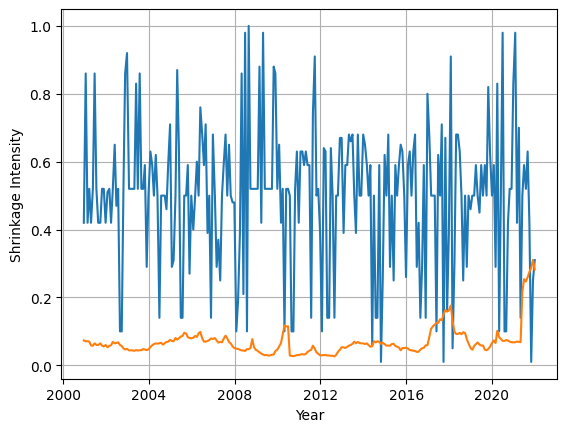

In [30]:
gail_preds = gail_policy.predict(X[len_train:])[0]
mapped_res = np.array(re_hf.map_preds_to_factors(gail_preds, all_factors)).astype(float)
#r = eval_function_new.eval_fct_networkonly_1YR(mapped_res, rets_full, permnos, 0, val_indices_results)
#eval_function_new.myplot(mapped_res[val_idxes_shrkges], cov1para_shrk[val_idxes_shrkges])

res_df = pd.DataFrame({"ElasticNet_CVC": mapped_res, "CVC": cov1para_shrk }, index=pd.to_datetime(permnos.index[5040:], format="%Y%m%d") )
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df)
ax.set(xlabel='Year', ylabel='Shrinkage Intensity')
ax.grid()

np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100

10.981974346282957

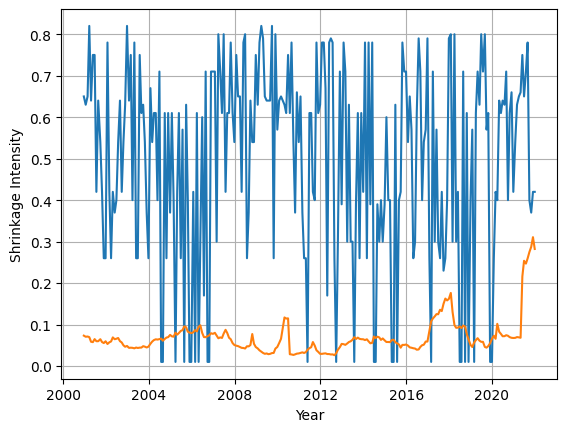

In [28]:
gail_preds = gail_policy.predict(X[len_train:])[0]
mapped_res = np.array(re_hf.map_preds_to_factors(gail_preds, all_factors)).astype(float)
#r = eval_function_new.eval_fct_networkonly_1YR(mapped_res, rets_full, permnos, 0, val_indices_results)
#eval_function_new.myplot(mapped_res[val_idxes_shrkges], cov1para_shrk[val_idxes_shrkges])

res_df = pd.DataFrame({"ElasticNet_CVC": mapped_res, "CVC": cov1para_shrk }, index=pd.to_datetime(permnos.index[5040:], format="%Y%m%d") )
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df)
ax.set(xlabel='Year', ylabel='Shrinkage Intensity')
ax.grid()

np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100

### In sample prediction

8.428581113401135

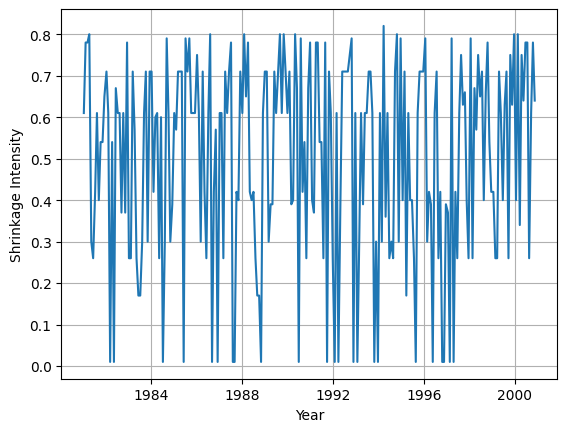

In [29]:
gail_preds = gail_policy.predict(X[:len_train])[0]
mapped_res = np.array(re_hf.map_preds_to_factors(gail_preds, all_factors)).astype(float)
#r = eval_function_new.eval_fct_networkonly_1YR(mapped_res, rets_full, permnos, 0, val_indices_results)
#eval_function_new.myplot(mapped_res[val_idxes_shrkges], cov1para_shrk[val_idxes_shrkges])

res_df = pd.DataFrame({"ElasticNet_CVC": mapped_res}, index=pd.to_datetime(permnos.index[:len_train], format="%Y%m%d") )
res_df = res_df.iloc[list(range(0, len_train, 21)), :]  # because we only may change intensity on every rebalancing date
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df)
ax.set(xlabel='Year', ylabel='Shrinkage Intensity')
ax.grid()

np.diag(rawres_fixed_shrk_data.iloc[:len_train, :].loc[:, mapped_res]).std()*np.sqrt(252)*100

In [ ]:
cov1para_insample = optimal_shrk_data['shrk_factor'].values[:len_train].astype(np.float64).round(2)


In [9]:
np.diag(rawres_fixed_shrk_data.iloc[:len_train, :].loc[:, cov1para_insample]).std()*np.sqrt(252)*100

NameError: name 'rawres_fixed_shrk_data' is not defined

### create a new env with random s,a,s_new distr. for testing
